# Image Classification using CNNs



*   Train a CNN on a small dataset using image augmentation and transfer learning
*   Dataset in kaggle: https://www.kaggle.com/datasets/saadpd/menwomen-classification





In [1]:
from google.colab import files
myfile = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset
!kaggle datasets download -d saadpd/menwomen-classification

 98% 787M/806M [00:04<00:00, 227MB/s]
100% 806M/806M [00:04<00:00, 195MB/s]


In [4]:
# !unzip -qq microsoft-catsvsdogs-dataset.zip
!unzip -qq menwomen-classification.zip

In [6]:
import os

num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))
num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print(f'Train: men: {num_men_train} | women: {num_women_train}')
print(f'Test: men: {num_men_test} | women: {num_women_test}')

Train: men: 1000 | women: 1912
Test: men: 418 | women: 915


In [7]:
import shutil, pathlib

new_base_dir = pathlib.Path("men_vs_women_small")

def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ("men", "women"):
        dir = new_base_dir / subset_name / category
        if not os.path.exists(dir):
            os.makedirs(dir)
        files = os.listdir(os.path.join(base_dir, category))
        fnames = [files[i] for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=os.path.join(base_dir, category, fname),
            dst=os.path.join(dir, fname))

In [8]:
make_subset("traindata/traindata", "train", start_index=0, end_index=700)
make_subset("traindata/traindata", "validation", start_index=500, end_index=999)
make_subset("testdata/testdata", "test", start_index=0, end_index=400)

## Using image_dataset_from_directory to read images

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, 'train'),
    image_size=(180, 180),
    label_mode='binary',
    labels='inferred',
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, 'validation'),
    image_size=(180, 180),
    label_mode='binary',
    labels='inferred',
    batch_size=32)
test_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, 'test'),
    image_size=(180, 180),
    label_mode='binary',
    labels='inferred',
    batch_size=32)

Found 1400 files belonging to 2 classes.
Found 998 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


In [12]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32, 1)


## Load pretrained model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [15]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [17]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

## Create Callbacks

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
    ]

## Training

In [19]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
44/44 [==============================] - 33s 423ms/step - loss: 27.0994 - accuracy: 0.7379 - val_loss: 15.9532 - val_accuracy: 0.8257
Epoch 2/50
44/44 [==============================] - 18s 370ms/step - loss: 13.5853 - accuracy: 0.8093 - val_loss: 12.5343 - val_accuracy: 0.8507
Epoch 3/50
44/44 [==============================] - 18s 367ms/step - loss: 12.8328 - accuracy: 0.8300 - val_loss: 10.0102 - val_accuracy: 0.8687
Epoch 4/50
44/44 [==============================] - 19s 386ms/step - loss: 9.3940 - accuracy: 0.8586 - val_loss: 9.3100 - val_accuracy: 0.8667
Epoch 5/50
44/44 [==============================] - 18s 365ms/step - loss: 8.7308 - accuracy: 0.8521 - val_loss: 10.6143 - val_accuracy: 0.8607
Epoch 6/50
44/44 [==============================] - 18s 370ms/step - loss: 7.6697 - accuracy: 0.8557 - val_loss: 8.0466 - val_accuracy: 0.8778
Epoch 7/50
44/44 [==============================] - 18s 385ms/step - loss: 5.0758 - accuracy: 0.8707 - val_loss: 6.8242 - val_accuracy:

## Displaying curves of loss and accuracy during training

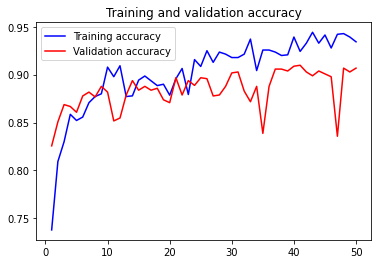

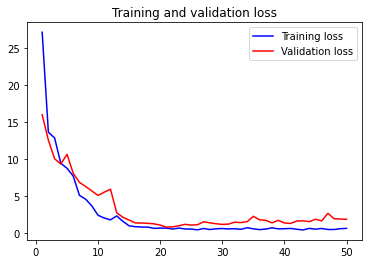

In [22]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Copy the trained model to Google Drive

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
!cp 'feature_extraction_with_data_augmentation.keras' '/content/drive/MyDrive/feature_extraction_with_data_augmentation.keras' 

## Evaluating the model on the test set

In [23]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 6s 184ms/step - loss: 0.8387 - accuracy: 0.8675
Test loss: 0.839
Test accuracy: 0.868


## Copy the trained model from Google Drive

In [ ]:
!cp '/content/drive/MyDrive/feature_extraction_with_data_augmentation.keras' 'feature_extraction_with_data_augmentation.keras' 

## Prediction on a new image

In [24]:
from google.colab import files
myfile = files.upload()

Saving OIP.jpg to OIP.jpg


In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = next(iter(myfile))
img = image.load_img(img_path, target_size=(180, 180))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = keras.applications.vgg16.preprocess_input(x)

In [26]:
pred = test_model.predict(x)

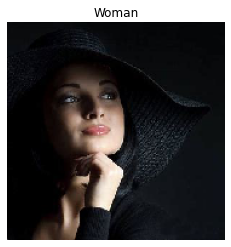

In [27]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis("off")
if pred<0.5:
    plt.title('Man')
else:
    plt.title('Woman')